# Identifying the outliers using spectral clustering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from scipy.spatial.distance import pdist, squareform
except ImportError:
    %pip install scikit-learn scipy
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from scipy.spatial.distance import pdist, squareform

In [2]:
df = pd.read_csv('data/data.csv')
df = df[:400]                                          # TODO: remove this line
n, d = df.shape
print('n =', n, 'd =', d)

pca = PCA(n_components=2)
pc = pca.fit_transform(StandardScaler().fit_transform(df))

n = 400 d = 10


## Similarity matrix

### $\epsilon$-neighborhood

In [3]:
def get_alphaNeighborhoodGraph(alpha, df, dist='euclidean'):
    """Compute the alpha-neighborhood graph of the data points in df.
    @param dist: distance metric to use (default: euclidean) `'euclidean' | 'cosine'`
    return A, L where A is the adjacency matrix and L is the Laplacian matrix.
    """
    assert dist in ['euclidean', 'cosine'], 'dist must be either `euclidean` or `cosine`'

    n = df.shape[0]
    A = np.zeros((n, n))
    distances = squareform(pdist(df, metric=dist))
    for i in range(n):
        for j in range(i + 1, n):
            if distances[i, j] <= alpha:
                A[i, j] = 1
                A[j, i] = 1

    D = np.diag(np.sum(A, axis=1))
    L = D - A
    return A, L


In [4]:
d = pdist(pc, metric='euclidean')
d.min(), d.max(), d.mean(), d.std()


(0.010951123138897395, 10.202812542368, 2.4538914259196942, 1.2516896464113376)

In [5]:
d = pdist(pc, metric='cosine')
d.min(), d.max(), d.mean(), d.std()

(2.2227997220625184e-11,
 1.9999999999999887,
 1.002412275947621,
 0.7092884467536963)

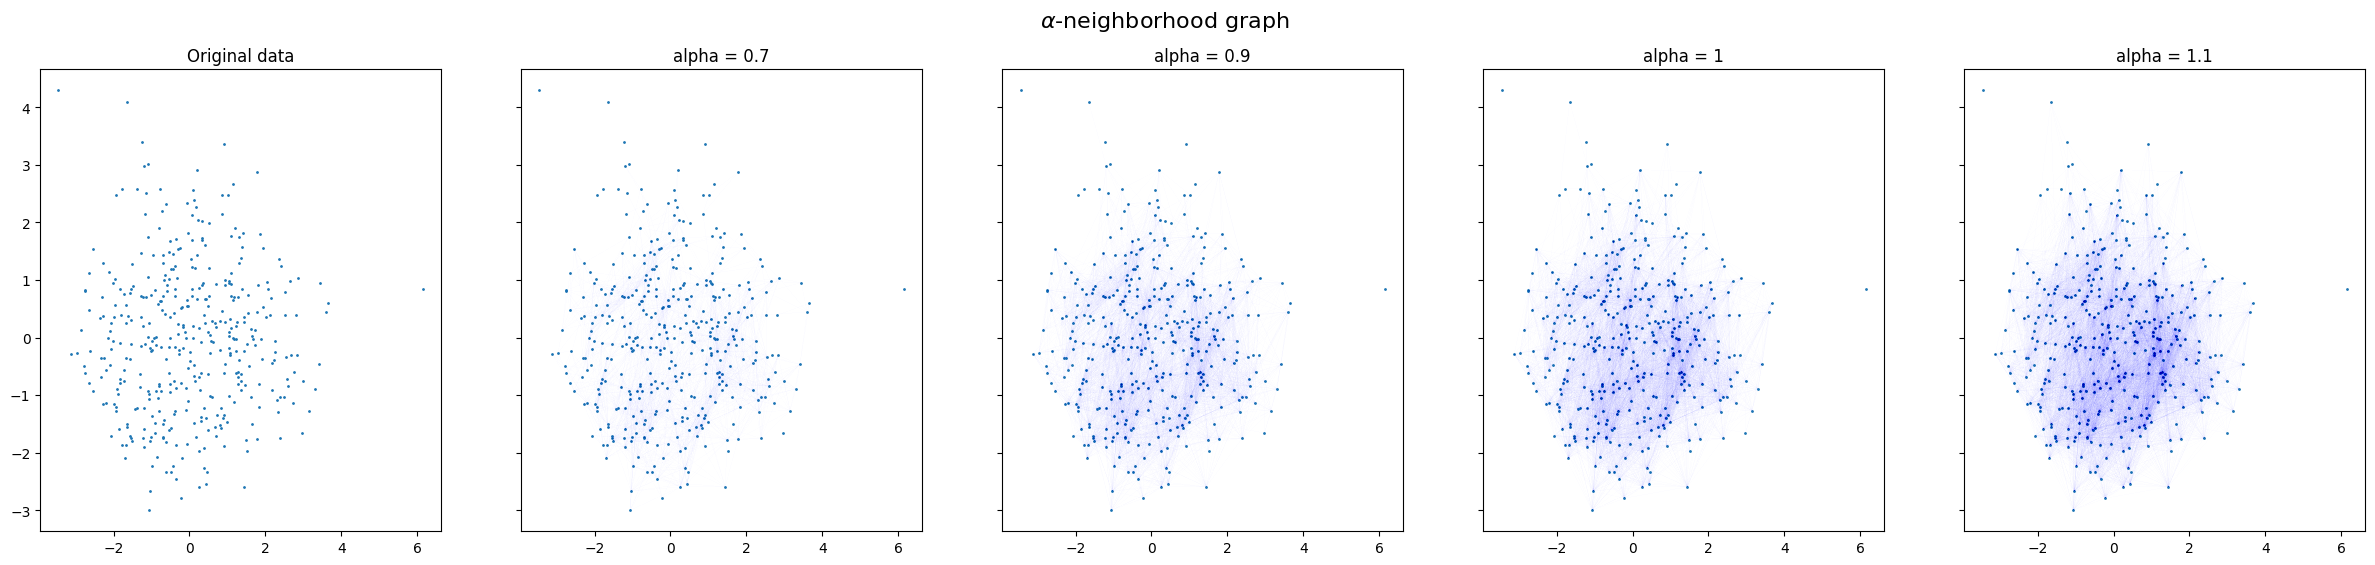

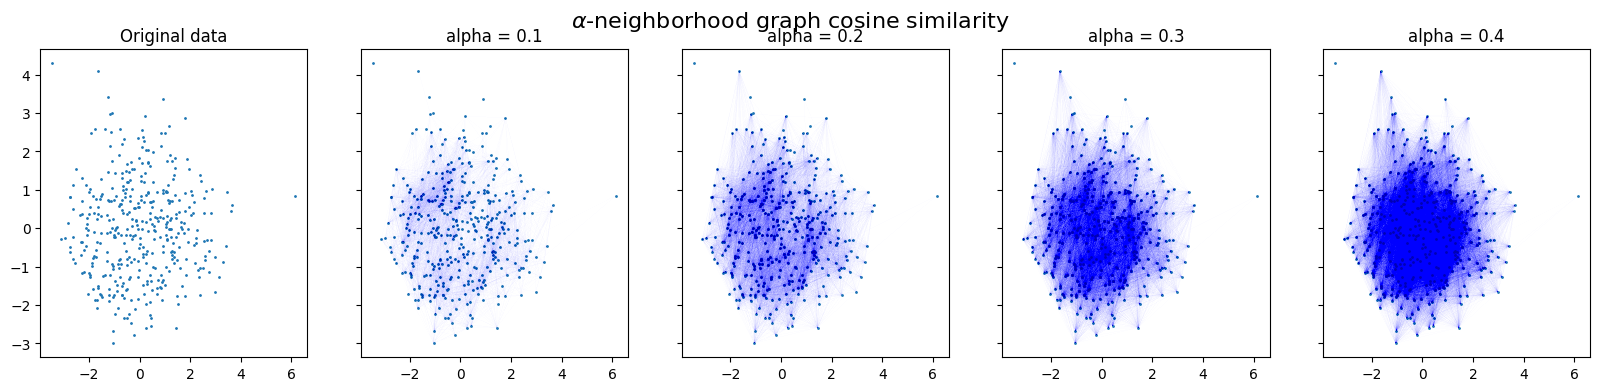

In [6]:
fig, ax = plt.subplots(1, 5, figsize=(30, 6), sharey=True, sharex=True)
ax[0].scatter(pc[:, 0], pc[:, 1], s=1)
ax[0].set_title('Original data')
visibility = 0.02
line_width = 0.1

# Parameter tuning for alpha
alphas = [0.7, 0.9, 1, 1.1 ]
for i, alpha in enumerate(alphas):
    A, L = get_alphaNeighborhoodGraph(alpha, df)
    ax[i + 1].scatter(pc[:, 0], pc[:, 1], s=1)
    ax[i + 1].set_title('alpha = {}'.format(alpha))
    for ind1, ind2 in zip(*np.where(A == 1)):
        ax[i + 1].plot(pc[[ind1, ind2], 0], pc[[ind1, ind2], 1], lw=line_width, c='b', alpha=visibility)

alpha = 1.1         # Best alpha TODO: set to the best alpha
fig.suptitle(r'$\alpha$-neighborhood graph', fontsize=16)
plt.savefig('images/alpha_neighborhood_graph.png')
plt.show()


fig, ax = plt.subplots(1, 5, figsize=(20, 4), sharey=True, sharex=True)
ax[0].scatter(pc[:, 0], pc[:, 1], s=1)
ax[0].set_title('Original data')

# Parameter tuning for alpha
alphas = [0.1, 0.2, 0.3, 0.4 ]
for i, alpha in enumerate(alphas):
    A, L = get_alphaNeighborhoodGraph(alpha, df, dist='cosine')
    ax[i + 1].scatter(pc[:, 0], pc[:, 1], s=1)
    ax[i + 1].set_title('alpha = {}'.format(alpha))
    for ind1, ind2 in zip(*np.where(A == 1)):
        ax[i + 1].plot(pc[[ind1, ind2], 0], pc[[ind1, ind2], 1], lw=line_width, c='b', alpha=visibility)

alpha = 1.1         # Best alpha TODO: set to the best alpha
fig.suptitle(r'$\alpha$-neighborhood graph cosine similarity', fontsize=16)
plt.savefig('images/alpha_neighborhood_graph_cosine_similarity.png')
plt.show()



### k-nearest neighbor

In [7]:
def get_kNNGraph(k, df, mutual=False, dist='euclidean'):
    """
    Compute the k-nearest neighbor graph of the data points in df.
    If mutual is True, only keep edges that are mutual. (i.e. (i,j) is an edge iff i is among the k-nearest neighbors of j and j is among the k-nearest neighbors of i)
    return A, L where A is the adjacency matrix and L is the Laplacian matrix.
    """
    n = df.shape[0]
    A = np.zeros((n, n))
    distances = pdist(df, dist)
    distances = squareform(distances)
    distances = np.where(distances == 0, np.inf, distances)

    neighbors = np.argsort(distances)[:, :k]
    for i in range(n):
        A[i, neighbors[i]] = 1

    if mutual:
        A = A * A.T
    else: 
        A = A + A.T - A*A.T

    D = np.diag(np.sum(A, axis=1))
    L = D - A
    return A, L


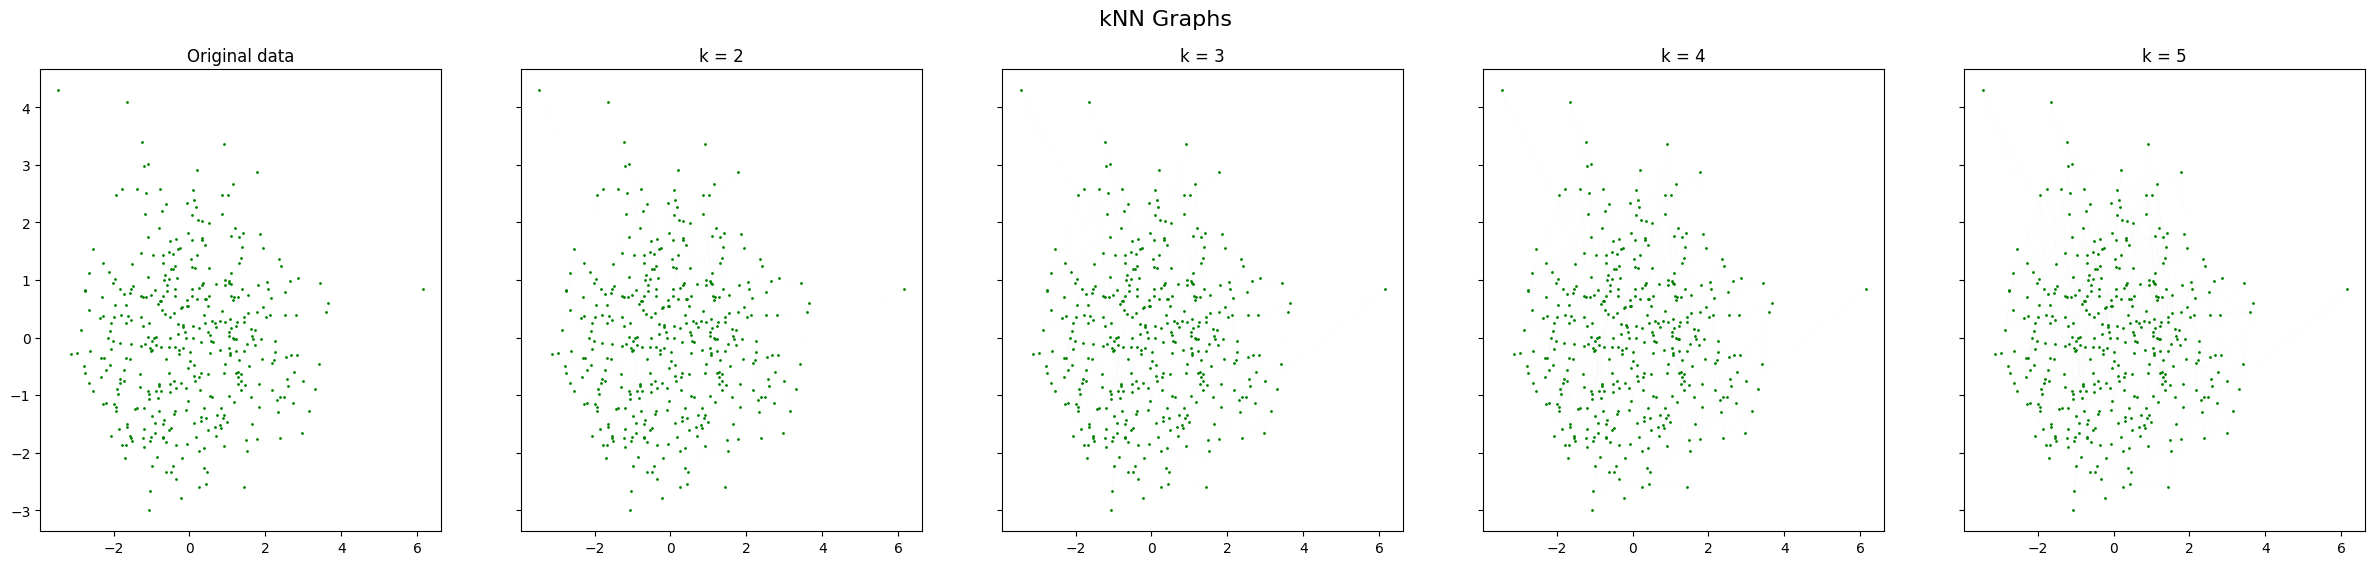

With mutual = True


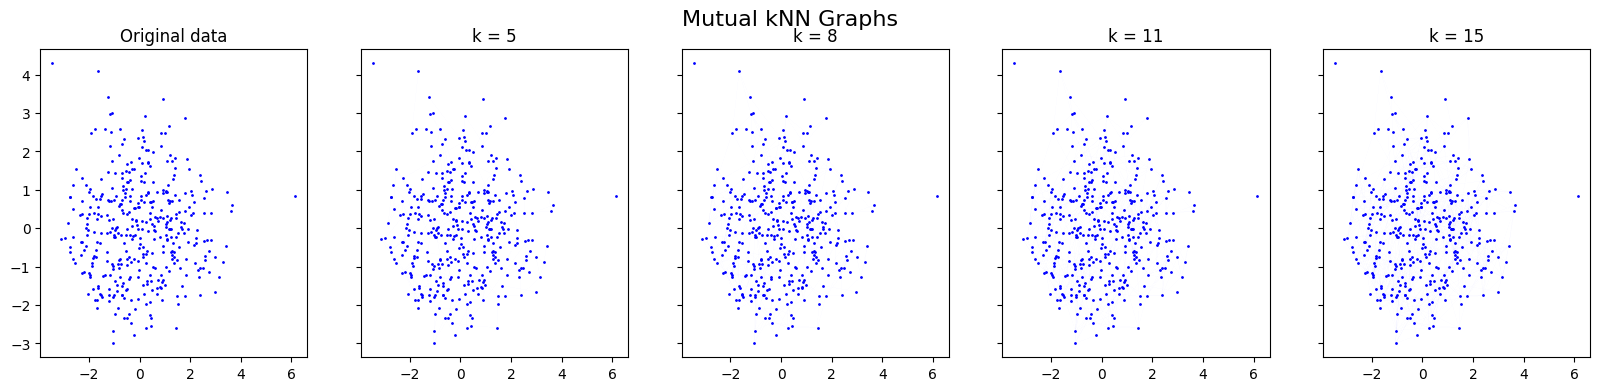

In [8]:
fig, ax = plt.subplots(1, 5, figsize=(30, 6), sharey=True, sharex=True)
ax[0].scatter(pc[:, 0], pc[:, 1], s=1, c='g')
ax[0].set_title('Original data')

# Parameter tuning for k
ks = [2, 3, 4, 5]
for i, k in enumerate(ks):
    A, L = get_kNNGraph(k, df, mutual=False)
    ax[i + 1].scatter(pc[:, 0], pc[:, 1], s=1, c='g')
    ax[i + 1].set_title('k = {}'.format(k))
    for ind1, ind2 in zip(*np.where(A == 1)):
        ax[i + 1].plot(pc[[ind1, ind2], 0], pc[[ind1, ind2], 1], lw=line_width, c='g', alpha=visibility)

k1 = 5        # Best k1 TODO: set to the best k1
fig.suptitle('kNN Graphs', fontsize=16)
plt.savefig('images/knn_graphs.png')
plt.show()

print("With mutual = True")
fig, ax = plt.subplots(1, 5, figsize=(20, 4), sharey=True, sharex=True)
ax[0].scatter(pc[:, 0], pc[:, 1], s=1, c='b')
ax[0].set_title('Original data')

# Parameter tuning for k
ks = [5, 8, 11, 15]
for i, k in enumerate(ks):
    A, L = get_kNNGraph(k, df, mutual=True)
    ax[i + 1].scatter(pc[:, 0], pc[:, 1], s=1, c='b')
    ax[i + 1].set_title('k = {}'.format(k))
    for ind1, ind2 in zip(*np.where(A == 1)):
        ax[i + 1].plot(pc[[ind1, ind2], 0], pc[[ind1, ind2], 1], lw=line_width, c='b', alpha=visibility)

k2 = 15        # Best k2 TODO: set to the best k2

# Set the global title of the figure
fig.suptitle('Mutual kNN Graphs', fontsize=16)
plt.savefig('images/mutual_knn_graphs.png')
plt.show()




### Fullly connected graph

In [9]:
def get_fullyConnectedGraph(df, sigma=1):
    """
    Compute the fully connected graph of the data points in df.
    return A, L where A is the adjacency matrix and L is the Laplacian matrix.
    """
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            A[i, j] = np.exp(-np.linalg.norm(df.iloc[i] - df.iloc[j]) ** 2 / (2 * sigma ** 2))
            A[j, i] = A[i, j]

    D = np.diag(np.sum(A, axis=1))
    L = D - A
    return A, L


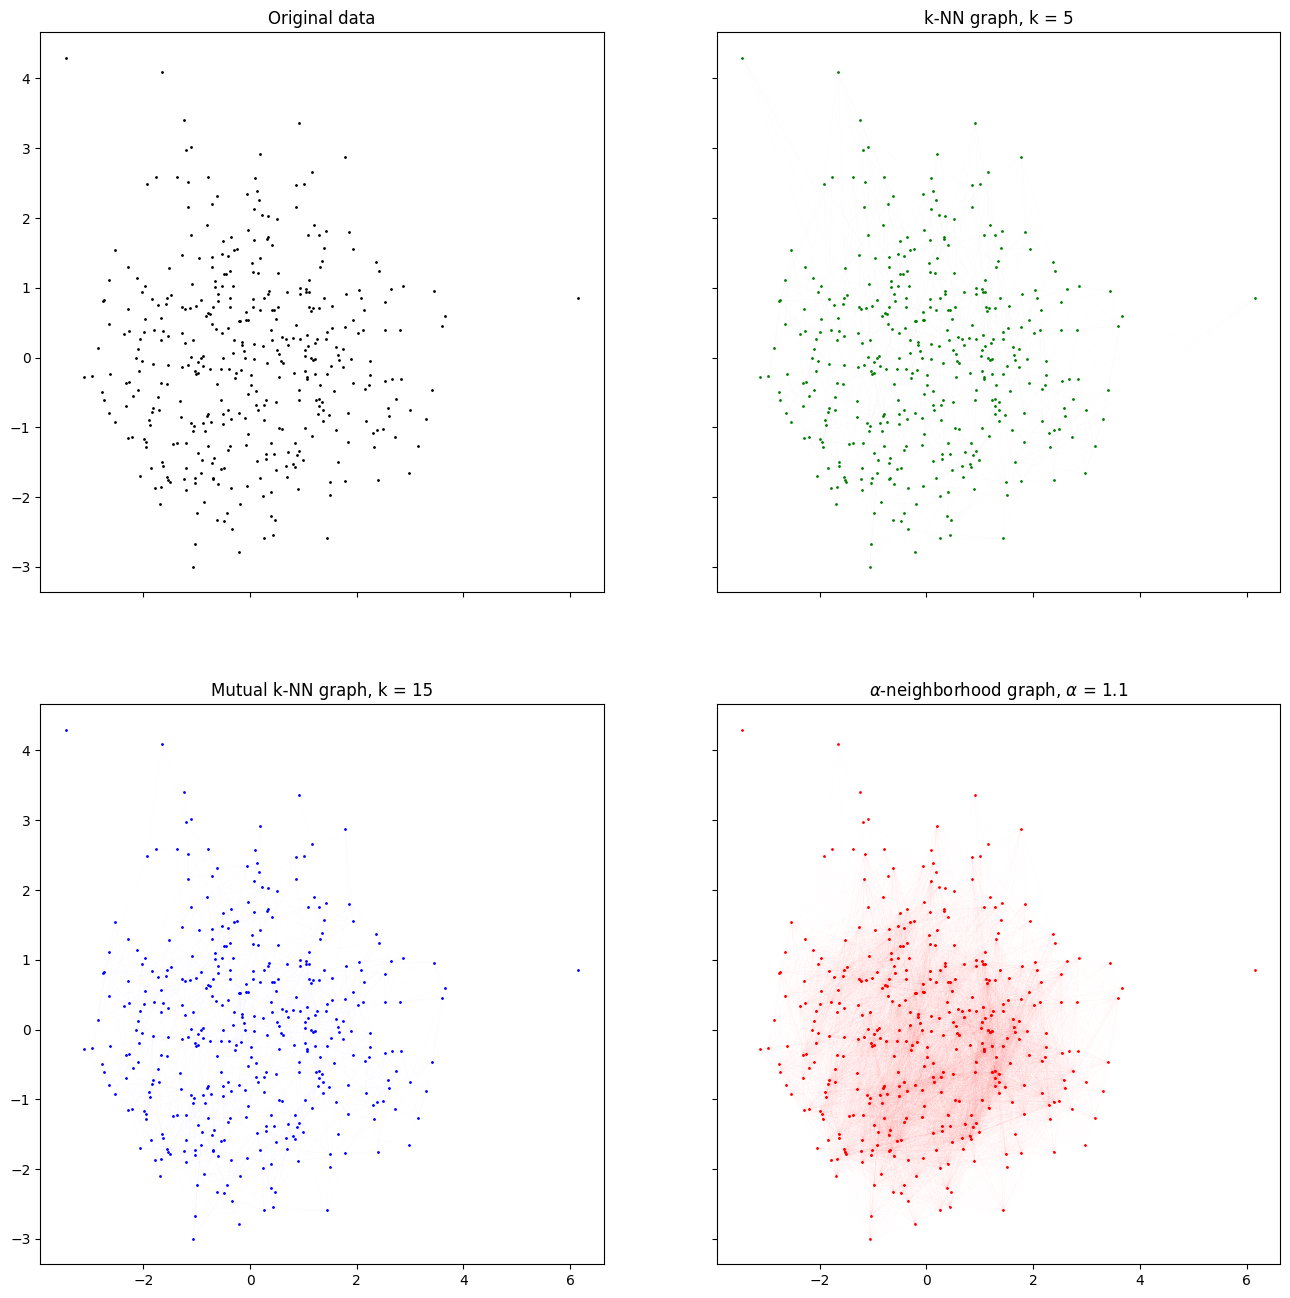

In [10]:
# Plot all the graphs with best parameters
fig, ax = plt.subplots(2, 2, figsize=(16, 16), sharey=True, sharex=True)
ax[0, 0].scatter(pc[:, 0], pc[:, 1], s=1, c='k')
ax[0, 0].set_title('Original data')

A, L = get_alphaNeighborhoodGraph(alpha, df)
ax[1, 1].scatter(pc[:, 0], pc[:, 1], s=1, c='r')
ax[1, 1].set_title(r'$\alpha$-neighborhood graph, $\alpha$ = {}'.format(alpha))
for ind1, ind2 in zip(*np.where(A == 1)):
    ax[1, 1].plot(pc[[ind1, ind2], 0], pc[[ind1, ind2], 1], lw=line_width, c='r', alpha=visibility)

A, L = get_kNNGraph(k1, df, mutual=False)
ax[0, 1].scatter(pc[:, 0], pc[:, 1], s=1, c='g')
ax[0, 1].set_title('k-NN graph, k = {}'.format(k1))
for ind1, ind2 in zip(*np.where(A == 1)):
    ax[0, 1].plot(pc[[ind1, ind2], 0], pc[[ind1, ind2], 1], lw=line_width, c='g', alpha=visibility)

A, L = get_kNNGraph(k2, df, mutual=True)
ax[1, 0].scatter(pc[:, 0], pc[:, 1], s=1, c='b')
ax[1, 0].set_title('Mutual k-NN graph, k = {}'.format(k2))
for ind1, ind2 in zip(*np.where(A == 1)):
    ax[1, 0].plot(pc[[ind1, ind2], 0], pc[[ind1, ind2], 1], lw=line_width, c='b', alpha=visibility)

plt.savefig('images/all_graphs_with_best_parameters.png')
plt.show()

In [11]:
def normalizeLaplacian(L, norm='sym'):
    """Compute the normalized Laplacian matrix of L.
    @param norm: type of normalization to use (default: symmetric normalization) `'sym' | 'rw'`
    return: normalized Laplacian matrix
    """
    assert norm in ['sym', 'rw'], 'norm must be either `sym` or `rw`'

    if norm == 'sym':
        D = np.diag(np.diag(L))
        D_sqrt = np.sqrt(np.linalg.inv(D))
        L_norm = D_sqrt @ L @ D_sqrt
    else:
        D = np.diag(np.diag(L))
        L_norm = np.linalg.inv(D) @ L

    return L_norm


# # Testing above functions
# L = np.array([[2, -1, -1], [-1,  2, -1], [-1, -1,  2]])
# L_norm = normalizeLaplacian(L, norm='sym')
# print('L_norm(sym) =\n', L_norm)
# L_norm = normalizeLaplacian(L, norm='rw')
# print('L_norm(rw) =\n', L_norm)


## Eigen decomposition 

In [12]:
def get_eigenvectors(L, k=-1):
    """Compute the k smallest eigenvalues and eigenvectors of L.
    return: eigenvalues, eigenvectors
    """
    eigenvalues, eigenvectors = np.linalg.eigh(L)
    idx = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    return eigenvalues[1:k], eigenvectors[:,1:k]

def eigenGap(eigenvalues, k):
    """Compute the eigen gap of the eigenvalues.
    return: eigen gap
    """
    return eigenvalues[k] - eigenvalues[k - 1]

def get_bestK(eigenvalues, max_k=10):
    """Compute the best k for the k-means algorithm.
    return: best k
    """
    eigenGap_values = [eigenGap(eigenvalues, k) for k in range(2, max_k)]
    return np.argmax(eigenGap_values) + 2

In [13]:
A_alpha, L_alpha = get_alphaNeighborhoodGraph(alpha, df)
A_kNN, L_kNN = get_kNNGraph(k1, df, mutual=False)
A_mutual, L_mutual = get_kNNGraph(k2, df, mutual=True)
A_full, L_full = get_fullyConnectedGraph(df)
A_full_norm, L_full_norm = A_full, normalizeLaplacian(L_full, norm='sym')
As = [A_alpha, A_kNN, A_mutual, A_full, A_full_norm]
Ls = [L_alpha, L_kNN, L_mutual, L_full, L_full_norm]


Best k for alpha-neighborhood graph: 4
Best k for k-NN graph: 9
Best k for Mutual k-NN graph: 9
Best k for Fully connected graph: 4
Best k for Fully connected graph, normalized: 2


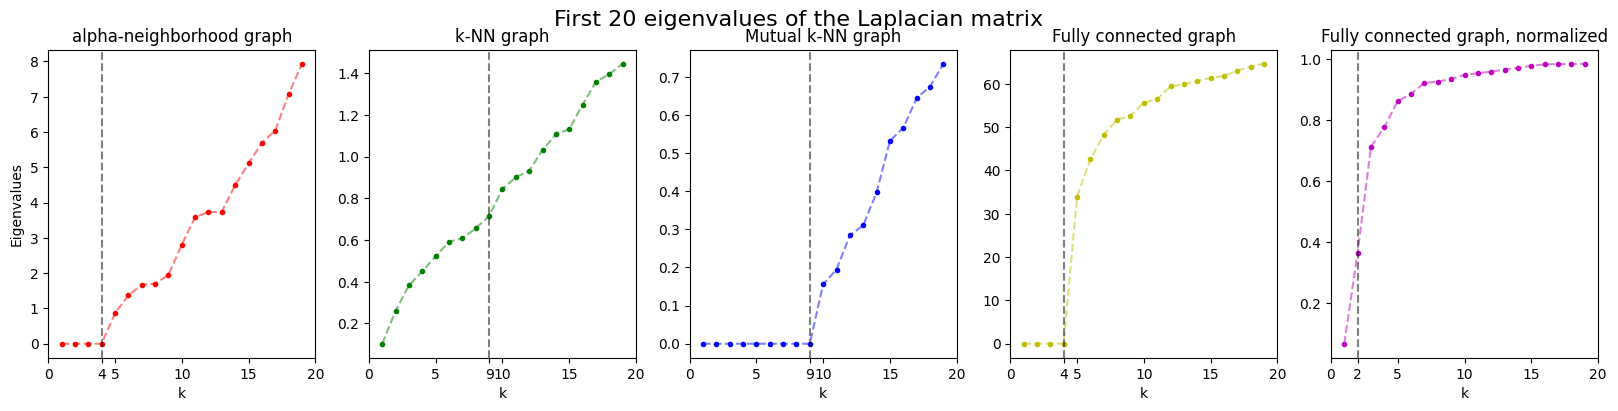

In [14]:
plots_titles = ['alpha-neighborhood graph', 'k-NN graph', 'Mutual k-NN graph', 'Fully connected graph', 'Fully connected graph, normalized']
C = ['r', 'g', 'b', 'y', 'm']
k = 20
x_values = np.arange(1, k)
best_Ks = []
eigenvectors_list = []

# Plotting the graphs
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    eigenvalues, eigenvectors = get_eigenvectors(Ls[i], k=k)
    eigenvectors_list.append(eigenvectors)
    best_k = get_bestK(eigenvalues)
    best_Ks.append(best_k)
    print('Best k for {}: {}'.format(plots_titles[i], best_k))
    ax[i].plot(x_values, eigenvalues, '.', c=C[i])
    ax[i].plot(x_values, eigenvalues, '--', c=C[i], alpha=0.5)
    ax[i].axvline(best_k, c='k', ls='--', alpha=0.5)
    ax[i].set_title(plots_titles[i])
    ax[i].set_xticks(np.append(ax[i].get_xticks(), best_k))
    ax[i].set_xlabel('k')
ax[0].set_ylabel('Eigenvalues')
fig.suptitle(f'First {k} eigenvalues of the Laplacian matrix', fontsize=16)
plt.show()

    

## Clustering Algorithms

### Recursive Bipartitioning clustering
- Recursive apply bi-partitioning algorithm
- Disadvantage: inefficient

In [15]:
def spectralClustering_recursive(df, K, L, eigenvectors):
    """Recursive spectral clustering algorithm.
    @param K: number of eigenValues to use
    @param L: Laplacian matrix (normalized or not)
    @param eigenvectors: eigenvectors of L
    @param labels: labels of the data points
    return: labels of the data points here just some IDs TODO: return the labels
    """
    assert eigenvectors.shape[1] >= K, 'k must be less than the number of eigenvectors'

    n = df.shape[0]
    labels = np.zeros(n, dtype=int)
    for k in range(K):
        for i in range(n):
            if np.dot(eigenvectors[:, k], L[i]) > 0:
                labels[i] ^= 2 << k

    # Map the labels to the range [0, K)
    lb, cnt = np.unique(labels, return_counts=True)
    idx = np.argsort(cnt)[::-1]
    lb = lb[idx]
    cnt = cnt[idx]
    for i in range(n):
        labels[i] = np.argwhere(lb == labels[i])[0][0]
    
    return labels
    


### cluster multiple eigenvectors   
- build a reduce space from multiple eigenvectors [shi & Malik, 2000]
- https://stats.stackexchange.com/questions/96539/motivations-for-shi-malik-algorithm

<!-- 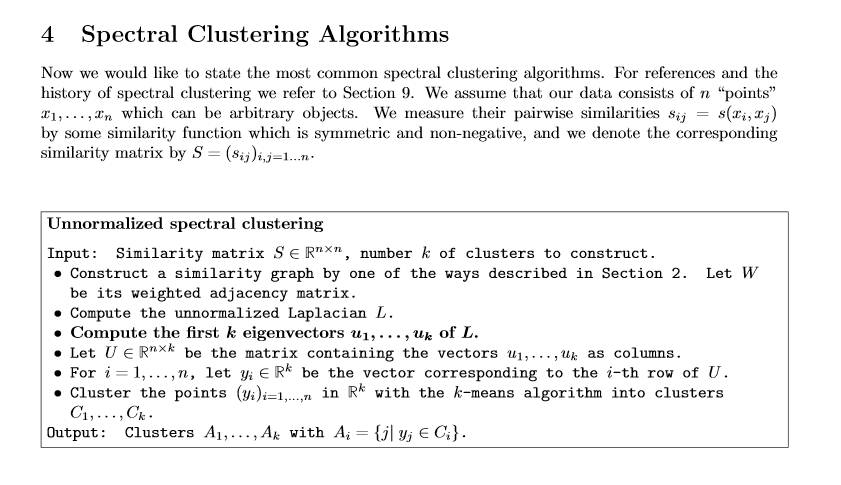 -->


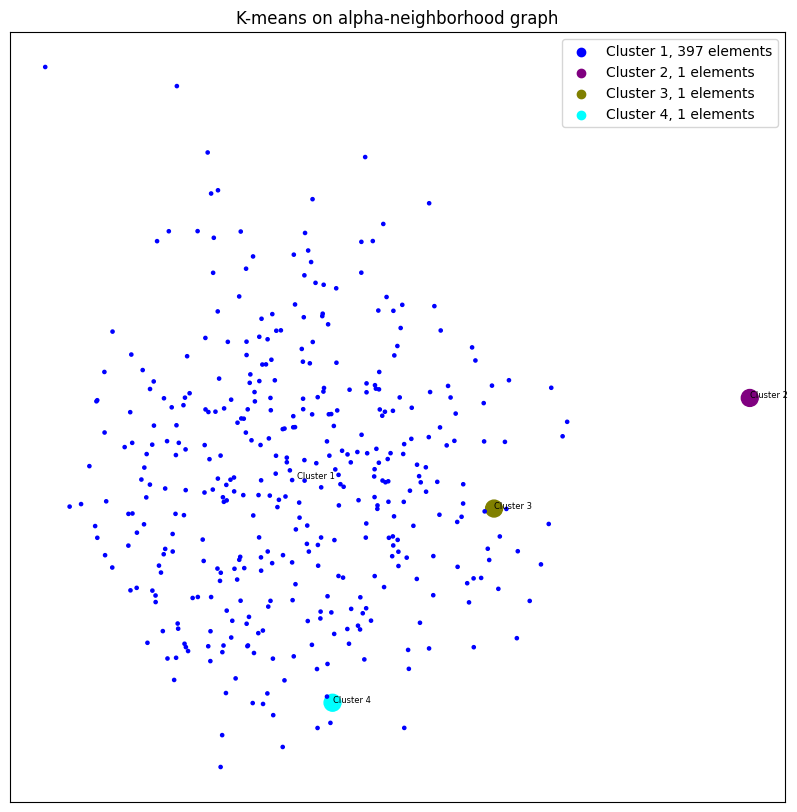

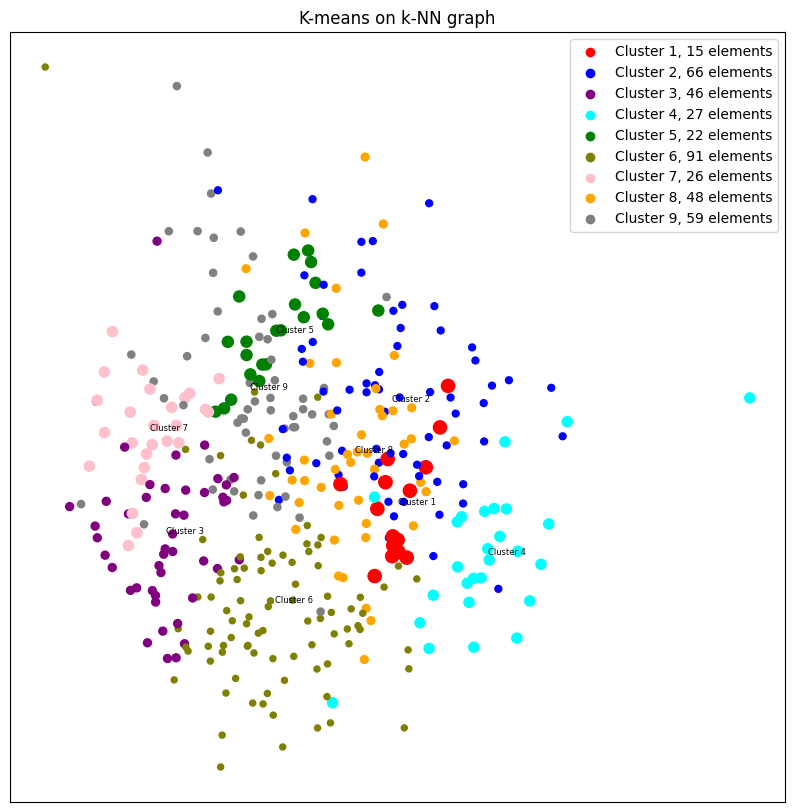

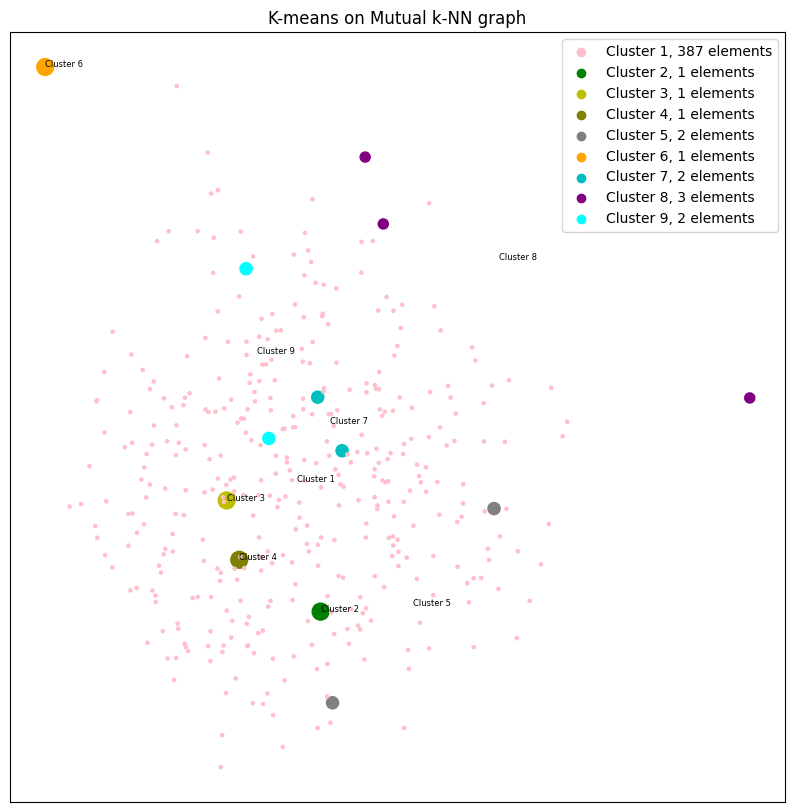

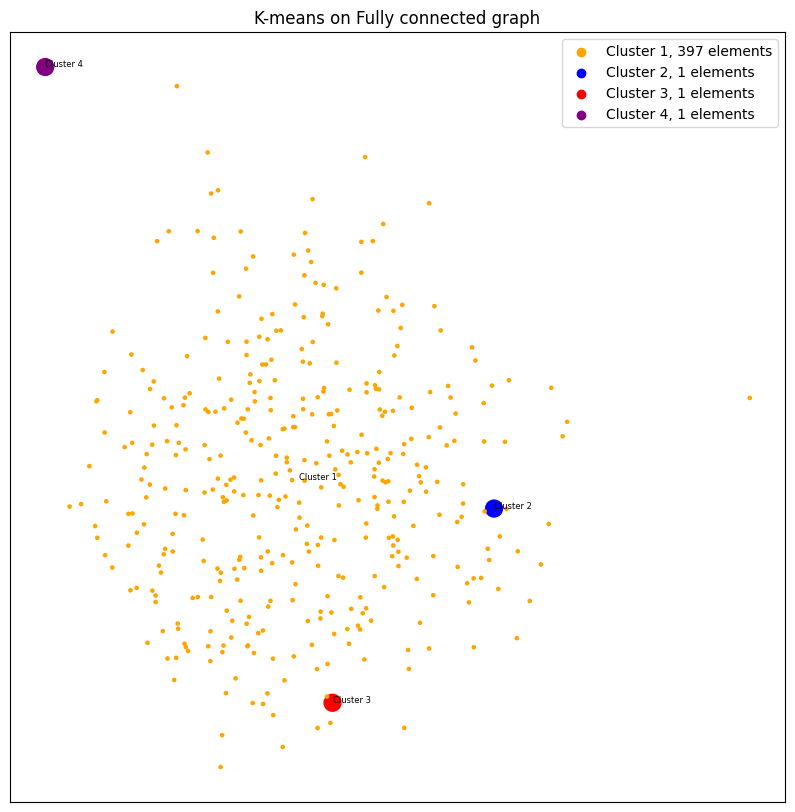

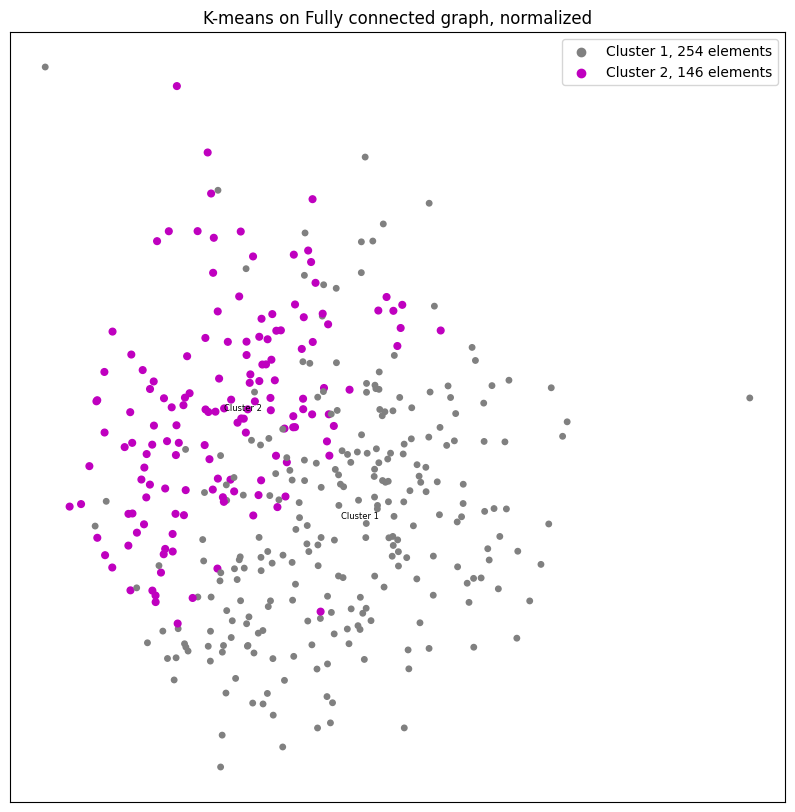

In [16]:
# Clustering using K-means
from sklearn.cluster import KMeans

colors = ['g', 'purple', 'r', 'b','orange', 'pink', 'y', 'm', 'gray','c', 'olive', 'cyan']

for i in range(5):
    plt.figure(figsize=(10, 10))
    kmeans = KMeans(n_clusters=best_Ks[i], random_state=0, n_init='auto').fit(eigenvectors_list[i][:, :best_Ks[i]])
    labels = kmeans.labels_
    # no of elements in each cluster
    cluster_sizes = np.bincount(labels)
    sizes = np.bincount(labels)
    # print(sizes)
    
    # size of dot to be inversely proportional to the size of the cluster integer between 1 to 10
    sizes_inv = 1/sizes
    sizes = 5 + 150*sizes_inv/np.max(sizes_inv + 5e-2)
    size_of_pnt = [ sizes[labels[i]] for i in range(n)]
    # print(sizes)
 
    np.random.shuffle(colors)
    c = [colors[(i)%len(colors) ] for i in labels]
    plt.scatter(pc[:, 0], pc[:, 1], c=c, s=size_of_pnt, alpha=1, edgecolors=c, marker='o')
    plt.title(f'K-means on {plots_titles[i]}')
    plt.xticks([])
    plt.yticks([])
    # add legend to the plot with the size of the cluster
    for i_ in range(len(np.unique(labels))):
        plt.scatter([], [], c=colors[i_], label=f'Cluster {i_+1}, {cluster_sizes[i_]} elements')

    plt.legend()

    K_ = best_Ks[i]
    for k_ in range(K_):
        plt.annotate('Cluster {}'.format(k_+1), (pc[labels == k_, 0].mean(), pc[labels == k_, 1].mean()), fontsize=6)
    
    plt.savefig(f'images/K-means on {plots_titles[i]}.png')
    plt.show()


## plots
- [x] data points, epsilons, k-nearest neighbors
- [x] eigenvalues
- [ ] spy graph ( sparcity of the graph)
<!-- - [ ] eigenvectors (Not know how, will it be usefull) -->

**Good Color Map**
- 'tab20', 'tab20b', 'tab20c'


- EigenGap, for choosing the number of clusters [Ng et al., 2002]